# IBM Advanced Data Science Capstone Project
## Sentiment Analysis of Amazon Customer Reviews
### Harsh V Singh, Apr 2021

## Model Definition

In this notebook, we will define the machine learning model that will be used to train and predict the sentiment of an Amazon customer's review given its review heading and text. We have already preprocessed the raw data into a training set containing tokenized and vectorized features of the review text content along with a binary review sentiment which is 1 for positive and 0 for negative reviews.

## Importing required Python libraries and initializing Apache Spark environment

In [3]:
import numpy as np
import pandas as pd
import math
import time
from pathlib import Path
from scipy import sparse
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import seaborn as sns

import sklearn
from sklearn.naive_bayes import ComplementNB
from sklearn import metrics

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM, Masking, Embedding
from keras import regularizers
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import findspark
findspark.init()

from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.types import StructType, StructField, DoubleType, IntegerType, StringType, ArrayType
from pyspark.sql.functions import udf, rand, col, concat, coalesce
from pyspark.ml.feature import HashingTF, IDF

CPU_CORES = 6
conf = SparkConf().setMaster("local[*]") \
    .setAll([("spark.driver.memory", "24g"),\
             ("spark.executor.memory", "4g"), \
             ("spark.driver.maxResultSize", "24g"), \
             ("spark.executor.cores", CPU_CORES), \
             ("spark.executor.heartbeatInterval", "3600s"), \
             ("spark.network.timeout", "7200s")])
sc = SparkContext.getOrCreate(conf=conf)
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .getOrCreate()

SEED_NUMBER = 1324

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
#spark.sparkContext.stop()

In [3]:
# Function to print time taken by a particular process, given the start and end times
def printElapsedTime(startTime, endTime):
    elapsedTime = endTime - startTime
    print("-- Process time = %.2f seconds --"%(elapsedTime))

## Method 1: Training models using TFIDF vectorized data

First, we will use the TFIDF vectorized data to build a baseline Naive Bayes model and then train a neural network with 2 hidden layers.

### Loading TFIDF train/ test data

We will begin by loading the train/ test data.


In [4]:
sourceDir = "data/sample/tfData"
X_train_tf = sparse.load_npz(sourceDir + "/X_train.npz")
X_test_tf = sparse.load_npz(sourceDir + "/X_test.npz")

X_train_tf.sort_indices()
X_test_tf.sort_indices()

y_train_tf = pd.read_csv(sourceDir + "/y_train.csv")["review_sentiment"].to_numpy()
y_test_tf = pd.read_csv(sourceDir + "/y_test.csv")["review_sentiment"].to_numpy()

In [5]:
print("X_train_tf is of type %s and shape %s."%(type(X_train_tf), X_train_tf.shape))
print("y_train_tf is of type %s, shape %s and %d unique classes."%(type(y_train_tf), y_train_tf.shape, len(np.unique(y_train_tf))))

X_train_tf is of type <class 'scipy.sparse.csr.csr_matrix'> and shape (31703, 71830).
y_train_tf is of type <class 'numpy.ndarray'>, shape (31703,) and 2 unique classes.


### Predictions using a Naive Bayes model for setting a baseline

**ComplementNB** implements the Complement Naive Bayes (CNB) algorithm. CNB is an adaptation of the standard multinomial naive Bayes (MNB) algorithm that is particularly suited for imbalanced data sets. CNB regularly outperforms MNB on text classification tasks so we will be using this model for our baseline.

In [6]:
tfCNBModel = ComplementNB().fit(X_train_tf, y_train_tf)
print("ComplementNB Accuracy: %.2f%%"%(100 * metrics.accuracy_score(y_test_tf, tfCNBModel.predict(X_test_tf))))

ComplementNB Accuracy: 83.08%


### Predictions using a Keras Neural Network

We will be using a **Sequential** model with **two** hidden layers and a **sigmoid** activation for the output layer. We can experiment with the hyperparameters such as *L2 regularization, dropout rate, number of nodes in the hidden layers and the activation functions* to find the best possible combination that gives the best accuracy on the test data.

In [8]:
# Plot the model accuracy and loss over the training epochs
def plotTrainingPerformance(history, figTitle, figSize=(12,5)):
    fig = plt.figure(figsize=figSize)
    sns.set_theme()
    sns.set_style("white")
    
    xvals = np.arange(len(history.history["accuracy"])) + 1

    fig.add_subplot(1, 2, 1)
    sns.lineplot(x=xvals, y=history.history["accuracy"])
    plt.xticks(xvals)
    plt.ylabel("accuracy")
        
    fig.add_subplot(1, 2, 2)
    sns.lineplot(x=xvals, y=history.history["loss"])
    plt.xticks(xvals)
    plt.ylabel("loss")
    
    fig.suptitle(figTitle)
    plt.show()

In [7]:
# Function to compile, fit and predict keras model
def fitAndPredictModel(modelName, model, X_train, y_train, X_test, y_test, loss, optimizer, metrics, epochs, batch_size):
    # Compile the model
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    # Fit the model on the training data
    history = model.fit(X_train, y_train.reshape((-1,1)), epochs=epochs, batch_size=batch_size)
    # Plot training performance
    plotTrainingPerformance(history=history, figTitle="Training Accuracy/ Loss over Epochs")
    # Predict review sentiments on the test data and check model accuracy
    _, accuracy = model.evaluate(X_test, y_test.reshape((-1,1)))
    print("%s Accuracy: %.2f%%" % (modelName, accuracy*100))

Epoch 1/5
d:\Projects\Python\IBM-Advanced-Data-Science-Capstone\.ibm_adv\lib\site-packages\tensorflow\python\framework\indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_7/dense_19/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_7/dense_19/embedding_lookup_sparse/Reshape:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_7/dense_19/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
248/248 [==============================] - 10s 34ms/step - loss: 0.6738 - accuracy: 0.6684
Epoch 2/5
248/248 [==============================] - 8s 33ms/step - loss: 0.4791 - accuracy: 0.8641
Epoch 3/5
248/248 [==============================] - 8s 33ms/step - loss: 0.4518 - accuracy: 0.8904
Epoch 4/5
248/248 [==============================] - 8s 

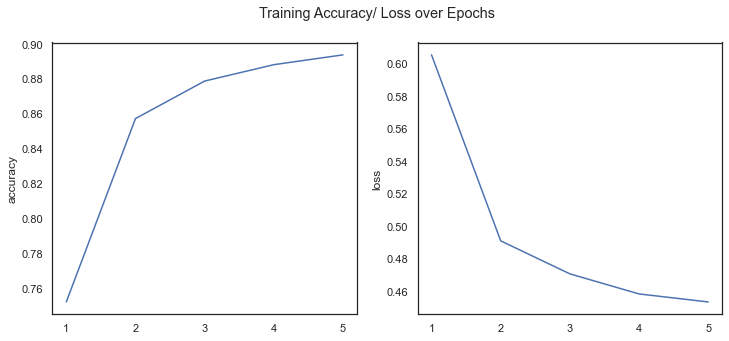

248/248 [==============================] - 2s 8ms/step - loss: 0.5074 - accuracy: 0.8597
Neural Network Accuracy: 85.97%


In [21]:
# Model definition
tfModel = Sequential()
l2Reg = 1e-3
dropout = 0.5
tfModel.add(Dense(32, input_shape=(X_train_tf.shape[1],), \
    kernel_regularizer=regularizers.l2(l2Reg), \
    bias_regularizer=regularizers.l2(l2Reg)))
tfModel.add(Activation('relu'))
tfModel.add(Dropout(dropout))
tfModel.add(Dense(32, input_shape=(X_train_tf.shape[1],), \
    kernel_regularizer=regularizers.l2(l2Reg), \
    bias_regularizer=regularizers.l2(l2Reg)))
tfModel.add(Activation('relu'))
tfModel.add(Dropout(dropout))
tfModel.add(Dense(1))
tfModel.add(Activation('sigmoid'))

# Complie, fit and predict model
fitAndPredictModel(
    modelName="Neural Network", model=tfModel, X_train=X_train_tf, y_train=y_train_tf, X_test=X_test_tf, y_test=y_test_tf, 
    loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"], epochs=5, batch_size=128)

## Method 2: Training models using sequential word vectors data

Now, we will use the sequential word vectors data to train a recurrent neural network with **1 LSTM layer**, **1 Dense layer** and a **sigmoid** output layer.

### Loading Sequential train/ test data

We will begin by loading the train/ test data.

In [4]:
sourceDir = "data/sample/seqData"
X_train_seq = np.load(sourceDir + "/X_train.npy")
X_test_seq = np.load(sourceDir + "/X_test.npy")
y_train_seq = pd.read_csv(sourceDir + "/y_train.csv")["review_sentiment"].to_numpy()
y_test_seq = pd.read_csv(sourceDir + "/y_test.csv")["review_sentiment"].to_numpy()

vocabCount = max([max(x) for x in X_train_seq]) + 1

### Predictions using a Keras LSTM Recurrent Neural Network

We will be using a **Sequential** model with **one** .... and a **sigmoid** activation for the output layer. We can experiment with the hyperparameters such as *L2 regularization, dropout rate, number of nodes in the hidden layers and the activation functions* to find the best possible combination that gives the best accuracy on the test data.

Epoch 1/5
248/248 [==============================] - 30s 105ms/step - loss: 0.6111 - accuracy: 0.6694
Epoch 2/5
248/248 [==============================] - 27s 109ms/step - loss: 0.3076 - accuracy: 0.8905
Epoch 3/5
248/248 [==============================] - 26s 105ms/step - loss: 0.2416 - accuracy: 0.9189
Epoch 4/5
248/248 [==============================] - 28s 114ms/step - loss: 0.1893 - accuracy: 0.9391
Epoch 5/5
248/248 [==============================] - 27s 110ms/step - loss: 0.1618 - accuracy: 0.9461


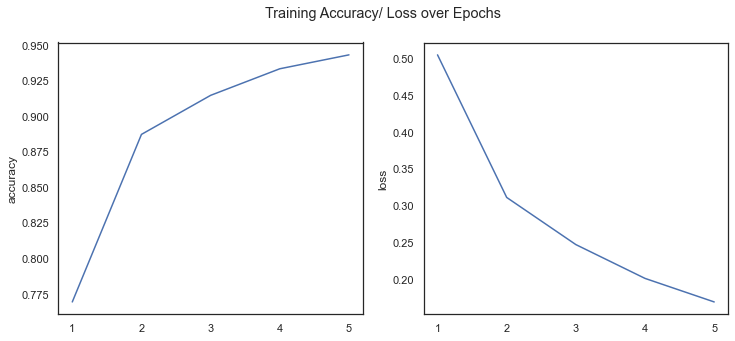

248/248 [==============================] - 2s 6ms/step - loss: 0.5402 - accuracy: 0.8415
LSTM RNN Accuracy: 84.15%


In [13]:
# Model definition
seqModel = Sequential()
l2Reg = 1e-2
dropout = 0.5
seqModel.add(Embedding(input_dim=vocabCount, output_dim=64, input_length=X_train_seq.shape[1], mask_zero=True))
seqModel.add(LSTM(32, return_sequences=False, dropout=dropout, recurrent_dropout=dropout))
seqModel.add(Dense(32, activation='relu', \
    kernel_regularizer=regularizers.l2(l2Reg), \
    bias_regularizer=regularizers.l2(l2Reg)))
seqModel.add(Dropout(dropout))
seqModel.add(Dense(1, activation='sigmoid'))

# Complie, fit and predict model
fitAndPredictModel(
    modelName="LSTM RNN", model=seqModel, X_train=X_train_seq, y_train=y_train_seq, X_test=X_test_seq, y_test=y_test_seq, 
    loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"], epochs=5, batch_size=128)